#### Reference-based

1. SciSci
2. Novelpy
3. Do it byself

#### 1. 用2003年和2004年的数据进行测试

##### load data

In [ ]:
"""
    思路:   
        （1）首先获得所有2003年的论文，并获得其对应的文件名
        （2）从论文中获取参考文献组合（IO密集型操作，多线程），可以以论文或以篇章为单位  以篇章为单位时，需考虑如何处理没有篇章的论文
        （3）计算新颖性
"""

In [3]:
import json

with open("../data/plos_pub_year.json", 'r') as f:
    pub_to_year = json.load(f)

with open("../data/plos_doi_to_name.json", "r") as f:
    doi_to_name = json.load(f)

In [4]:
reserve_dois = []

for doi, years in zip(pub_to_year.keys(), pub_to_year.values()):
    year = 0
    try:
        year = int(years['ppub'])
    except:
        year = int(years['epub'])
    
    if year == 2003:
        reserve_dois.append(doi)

print(len(reserve_dois))

91


In [5]:
reserve_names = []

for doi in reserve_dois:
    doi = doi.replace('\n','').strip()
    try:
        reserve_names.append(doi_to_name[doi])
    except:
        print(doi)
        continue

##### 1.1 模块测试

In [4]:
# 读单篇论文的reference及其组合关系
import os

with open(os.path.join("../data/plos", reserve_names[0]), 'r') as f:
    metadata = json.load(f)

refer_items = metadata['reference']

refer_ids, refer_journals = [], []

for item in refer_items:
    refer_ids.append(item['id'])
    refer_journals.append(item['source'])

id_to_journal = {id:journal for id, journal in zip(refer_ids, refer_journals)}

In [20]:
co_occurences = {}

def stat_co_occurence(journal_list):
    for idx_1, refer_1 in enumerate(refer_journals[:-1]):
        if refer_1 not in co_occurences:
            # co_occurences[refer_1] = {}
            co_occurences[refer_1] = []
            for idx_2, refer_2 in enumerate(refer_journals[idx_1:]):
                if refer_1 == refer_2:
                    continue
                co_occurences[refer_1].append(refer_2)
                # if refer_2 in co_occurences[refer_1]:
                #     co_occurences[refer_1][refer_2] += 1
                # else:
                #     co_occurences[refer_1][refer_2] = 1

In [21]:
# 单篇中也可不考虑共现次数
co_occurences = {}

stat_co_occurence(refer_journals)

print(co_occurences)

{'Mol Cell Biol': ['Science', 'J Mol Biol', 'Cell', 'J Immunol', 'Genome Biol', 'J Exp Med', 'Cell', 'Nature', 'Immunogenetics', 'Science', 'Mol Cell', 'Annu Rev Immunol', 'Mol Cell', 'J Mol Biol', 'Cell', 'Genes Dev', 'Adv Immunol', 'Cell', 'Mol Cell', 'EMBO J', 'Immunity', 'Mol Cell', 'Nucleic Acids Res', 'Immunity', 'Semin Immunol', 'J Exp Med', 'J Biol Chem', 'J Exp Med', 'Proc Natl Acad Sci U S A', 'Nucleic Acids Res', 'Nucleic Acids Res', 'Immunity', 'Cell', 'Cell', 'EMBO J', 'Eur J Immunol', 'Immunity', 'Nature', '', 'Genes Dev', 'J Biol Chem'], 'Science': ['J Mol Biol', 'Cell', 'J Immunol', 'Genome Biol', 'J Exp Med', 'Cell', 'Nature', 'Mol Cell Biol', 'Immunogenetics', 'Mol Cell', 'Annu Rev Immunol', 'Mol Cell', 'J Mol Biol', 'Cell', 'Genes Dev', 'Adv Immunol', 'Cell', 'Mol Cell', 'EMBO J', 'Immunity', 'Mol Cell', 'Nucleic Acids Res', 'Immunity', 'Semin Immunol', 'J Exp Med', 'J Biol Chem', 'Mol Cell Biol', 'J Exp Med', 'Mol Cell Biol', 'Proc Natl Acad Sci U S A', 'Nucleic Aci

In [23]:
# 以篇章为单位统计共现关系
sec_items = metadata['section']

co_occurences = {}

for sec in sec_items:
    sec_id = sec['refer']
    sec_refer = [id_to_journal[id] for id in sec_id]
    
    stat_co_occurence(sec_refer)

print(co_occurences)

{'Mol Cell Biol': ['Science', 'J Mol Biol', 'Cell', 'J Immunol', 'Genome Biol', 'J Exp Med', 'Cell', 'Nature', 'Immunogenetics', 'Science', 'Mol Cell', 'Annu Rev Immunol', 'Mol Cell', 'J Mol Biol', 'Cell', 'Genes Dev', 'Adv Immunol', 'Cell', 'Mol Cell', 'EMBO J', 'Immunity', 'Mol Cell', 'Nucleic Acids Res', 'Immunity', 'Semin Immunol', 'J Exp Med', 'J Biol Chem', 'J Exp Med', 'Proc Natl Acad Sci U S A', 'Nucleic Acids Res', 'Nucleic Acids Res', 'Immunity', 'Cell', 'Cell', 'EMBO J', 'Eur J Immunol', 'Immunity', 'Nature', '', 'Genes Dev', 'J Biol Chem'], 'Science': ['J Mol Biol', 'Cell', 'J Immunol', 'Genome Biol', 'J Exp Med', 'Cell', 'Nature', 'Mol Cell Biol', 'Immunogenetics', 'Mol Cell', 'Annu Rev Immunol', 'Mol Cell', 'J Mol Biol', 'Cell', 'Genes Dev', 'Adv Immunol', 'Cell', 'Mol Cell', 'EMBO J', 'Immunity', 'Mol Cell', 'Nucleic Acids Res', 'Immunity', 'Semin Immunol', 'J Exp Med', 'J Biol Chem', 'Mol Cell Biol', 'J Exp Med', 'Mol Cell Biol', 'Proc Natl Acad Sci U S A', 'Nucleic Aci

##### 1.2 novelpy新颖性计算 --论文级别

In [24]:
"""
    需将数据组织成以下形式
        {
            'PMID': 20097031,
            'c04_referencelist': [{'item': '0195-7910', 'year': 2001}],
            'year': 2012
        }
"""

In [ ]:
from fastnovelpy.utils import cooc_utils

# get combination
ref_cooc = cooc_utils.create_cooc(
    collection_name = 'paper_level',
    year_var = 'year',
    var = 'reference',
    sub_var = 'source',
    weighted_network = True,
    self_loop = True
)

ref_cooc.main()

In [1]:
from fastnovelpy.indicators import *

uzzi_novelty = Uzzi2013(collection_name='paper_level',
                        id_variable='doi',
                        year_variable='year',
                        variable='reference',
                        focal_year=2023,
                        sub_variable='source',
                        density=True)

In [ ]:
uzzi_novelty.get_indicator()

##### 1.3 novelpy新颖性计算 -- section level

In [ ]:
uzzi_novelty.get_indicator()

In [5]:
import os

with open(os.path.join("../data/plos", reserve_names[0]), 'r') as f:
    metadata = json.load(f)

refer_items = metadata['reference']
refer_ids, refer_journals = [], []

for item in refer_items:
    refer_ids.append(item['id'])
    refer_journals.append(item['source'])

id_to_journal = {id:journal for id, journal in zip(refer_ids, refer_journals)}

In [6]:
sec_items = metadata['section']

for sec in sec_items:
    new_metadata = {
        'doi': metadata['doi'] + '_' + sec['name'],
        'year': year
    }
    sec_id = sec['refer']
    sec_refer = [id_to_journal[id] for id in sec_id]
    new_metadata['reference'] = sec_refer

    json_metadata = json.dumps(new_metadata, indent=4)
    print(json_metadata)

{
    "doi": "10.1371/journal.pbio.0000001_Introduction",
    "year": 2013,
    "reference": [
        "Cell",
        "Annu Rev Immunol",
        "Adv Immunol",
        "Mol Cell",
        "EMBO J",
        "Mol Cell Biol",
        "Science",
        "Cell",
        "Mol Cell Biol",
        "Nucleic Acids Res",
        "Cell",
        "Cell",
        "Immunity",
        "Nature",
        "Science",
        "J Immunol",
        "Genes Dev",
        "Nucleic Acids Res",
        "Proc Natl Acad Sci U S A",
        "Nucleic Acids Res",
        "Eur J Immunol",
        "Nature",
        "Mol Cell Biol",
        "Science",
        "Immunogenetics",
        "Genes Dev",
        "Nucleic Acids Res",
        "J Exp Med",
        "Nucleic Acids Res",
        "Nature",
        "J Biol Chem",
        "Science",
        "J Exp Med",
        "Nucleic Acids Res",
        "EMBO J",
        "Mol Cell Biol",
        "Cell",
        "Immunity",
        "Immunogenetics",
        "Nucleic Acids Res",
    

#### 2. Mesh-based

##### 不考虑篇章结构时

当并不直接度量论文的新颖性，而先度量组合的新颖性时，此时要考虑的一个问题是如何汇总得到论文的新颖性

已知做法：

    1. uzzi: 用一篇论文中所有组合的第10th分位数作为论文的新颖性

    2. Liu: 用10th分位数作为阈值得到新颖组合，然后用论文中新颖组合占整体的比值作为论文的新颖性

还有个组合出现频次的问题🤔

##### 2.1 一篇论文相较于过去N年出现的新Mesh组合的比例

In [1]:
import itertools
from tqdm import tqdm
import json

focal_year = 2010
past_n = 3

past_combinations = []
focal_combinations = []
focal_paper_combinations = {}

# 构建历史Mesh组合
for n in range(past_n):
    year = focal_year - (n+1)
    with open("../Data/docs/paper_mesh_level/{}.json".format(year), 'r') as f:
        datas = json.load(f)
    
    for data in tqdm(datas):
        meshs = list(sorted(set(data['mesh'])))
        past_combinations.extend(itertools.combinations(meshs, 2))

with open("../Data/docs/paper_mesh_level/{}.json".format(focal_year), 'r') as f:
    datas = json.load(f)

for data in tqdm(datas):
    meshs = list(sorted(set(data['mesh'])))
    focal_paper_combinations[data['doi']] = list(itertools.combinations(meshs, 2))
    focal_combinations.extend(itertools.combinations(meshs, 2))

print(len(past_combinations))
print(past_combinations[:5])
print(len(focal_combinations))
print(focal_combinations[:5])

100%|██████████| 8987/8987 [00:00<00:00, 36884.09it/s]

2578645
[('ANOVA', 'Behavior'), ('ANOVA', 'Buffer'), ('ANOVA', 'Cartoons'), ('ANOVA', 'Chromosome'), ('ANOVA', 'Cryptochromes')]
2028217
[('Chromosome', 'DNA'), ('Chromosome', 'Gene'), ('Chromosome', 'Genes'), ('Chromosome', 'RNA'), ('DNA', 'Gene')]


In [2]:
new_combinations = set(focal_combinations) - set(past_combinations)
len(new_combinations)

342424

In [ ]:
focal_paper_indicators = {}

for focal_paper in tqdm(focal_paper_combinations.keys()):
    new_cnt = 0
    try:
        combinations = focal_paper_combinations[focal_paper]
        for combination in combinations:
            if combination in new_combinations:
                new_cnt += 1
        focal_paper_indicators[focal_paper] = {
            'Number of New': new_cnt,
            'Percentage of New': new_cnt/len(list(combinations)),
            'All': len(list(combinations))
        }
    except Exception as e:
        print(f"{focal_paper}: {e}")

##### 2.2 从语义相似度上考虑组合的新颖性

In [1]:
import os
import json

path = "mesh/Result/semantic/"
year = 2004

with open(os.path.join(path, f"{year}_semantic_biobert.json"), 'r') as f:
    datas = json.load(f)

all_similarities = []

new_datas = {}
for doi in datas:
    similarities = [1-value for value in datas[doi]]
    new_datas[doi] = similarities
    all_similarities.extend(similarities)

all_similarities.sort()

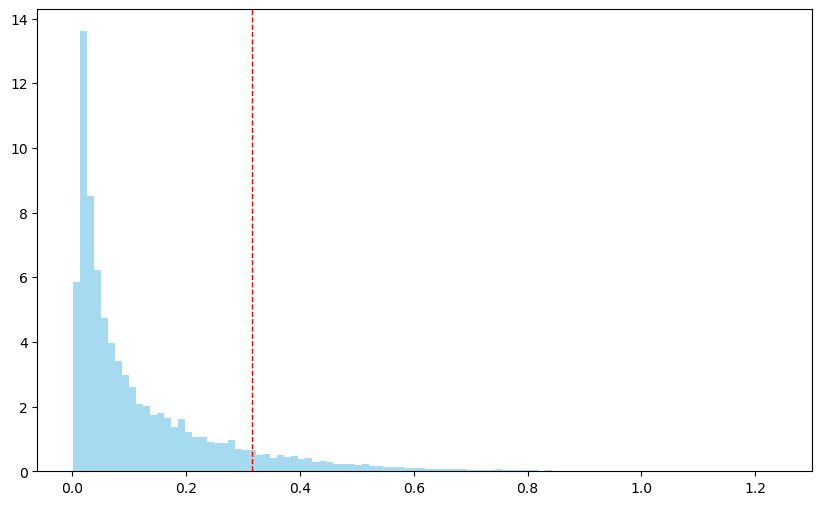

In [3]:
import numpy as np
import matplotlib.pyplot as plt

all_similarities = np.array(all_similarities)
percentile_10 = np.percentile(all_similarities, 90)

plt.figure(figsize=(10,6))
plt.hist(all_similarities, bins=100, density=True, alpha=0.75, color='skyblue')
plt.axvline(percentile_10, color='red', linestyle='--', linewidth=1)

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 20))
years = range(2003, 2013)

for i, (ax, year) in enumerate(zip(axs.flat, years)):
    with open(os.path.join(path, f"{year}_semantic_biobert.json"), 'r') as f:
        datas = json.load(f)

    all_similarities = []
    new_datas = {}
    for doi in datas:
        similarities = [1-value for value in datas[doi]]
        new_datas[doi] = similarities
        all_similarities.extend(similarities)
    all_similarities.sort()

    all_similarities = np.array(all_similarities)
    percentile_10 = np.percentile(all_similarities, 10)

    ax.hist(all_similarities, bins=50, density=True, alpha=0.75, color='skyblue')
    ax.axvline(percentile_10, color='red', linestyle='dashed', linewidth=2, label=f'10th percentile: {percentile_10:.4f}')

    ax.set_title(f"Year: {year}")
    ax.set_xlabel("Similarity")
    ax.set_ylabel("Density")

    ax.legend()

plt.tight_layout()

plt.show()

In [ ]:
paper_to_novelty = {}

for paper in new_datas:
    similarities = new_datas[paper]
    cnt = 0
    for sim in similarities:
        if sim < percentile_10:
            cnt += 1
    try:
        paper_to_novelty[paper] = cnt/len(similarities)
    except:
        paper_to_novelty[paper] = 0
        
paper_to_novelty

In [3]:
"""
    按照刘美君的方式，可以有两种计算方法：

        1. 每年分开考虑，即计算实体组合的新颖性时，只考虑组合在当年所有组合中的新颖程度
        2. 所有年份一起考虑

    结果似乎可以存在一个文件当中
"""

path = "mesh/Result/semantic/"

from tqdm import tqdm
import os
import json
import numpy as np

def cal_novelty_by_year():
    years = range(2003, 2025)

    paper_to_novelty = {}
    for year in tqdm(years):
        with open(os.path.join(path, f"{year}_semantic_biobert.json"), 'r') as f:
            datas = json.load(f)

        all_similarities = []
        new_datas = {}

        for doi in datas:
            similarities = [1-value for value in datas[doi]]
            new_datas[doi] = similarities
            all_similarities.extend(similarities)

        all_similarities.sort()
        all_similarities = np.array(all_similarities)
        percentile_10 = np.percentile(all_similarities, 90)

        for paper in new_datas:
            similarities = new_datas[paper]
            cnt = 0
            for sim in similarities:
                if sim > percentile_10:
                    cnt += 1
            try:
                paper_to_novelty[paper] = {
                    'novelty': cnt/len(similarities),
                    'year': year
                }
            except Exception as e:
                paper_to_novelty[paper] = {
                    'novelty': 0,
                    'year': year
                }
    
    return paper_to_novelty

def cal_novelty_all_years():
    years = range(2003, 2025)
    all_similarities = []
    new_datas = {}
    
    for year in tqdm(years):
        with open(os.path.join(path, f"{year}_semantic_biobert.json"), 'r') as f:
            datas = json.load(f)

        for doi in datas:
            similarities = [1-value for value in datas[doi]]
            new_datas[doi] = {
                'sim': similarities,
                'year': year
            }
            all_similarities.extend(similarities)

    all_similarities.sort()
    all_similarities = np.array(all_similarities)
    percentile_10 = np.percentile(all_similarities, 90)

    paper_to_novelty = {}
    for paper in new_datas:
        similarities = new_datas[paper]['sim']
        year = new_datas[paper]['year']
        cnt = 0
        for sim in similarities:
            if sim > percentile_10:
                cnt += 1
        try:
            paper_to_novelty[paper] = {
                'novelty': cnt/len(similarities),
                'year': year
            }
        except Exception as e:
            paper_to_novelty[paper] = {
                'novelty': 0,
                'year': year
            }
    
    return paper_to_novelty

In [4]:
paper_novelty = cal_novelty_by_year()
json_datas = json.dumps(paper_novelty, indent=4)
with open("mesh/Result/semantic/novelty_by_each_year.json", "w") as f:
    f.write(json_datas)

# paper_novelty = cal_novelty_all_years()
# json_datas = json.dumps(paper_novelty, indent=4)
# with open("mesh/Result/semantic/novelty_by_all_year.json", "w") as f:
#     f.write(json_datas)

100%|██████████| 22/22 [00:49<00:00,  2.25s/it]


##### 2.3 观测值与期望值的比值

In [6]:
"""
    uzzi的做法，通过构建零网络并与真实情况进行比较，是出于这一思想

    LiJiang(Effect of the topic-combination novelty on the disruption and impact of scientific articles) 一文也是类似的做法

    尚未弄清楚为什么可以这样， 道理何在
"""

import json
from collections import Counter
from tqdm import tqdm
import itertools
import math
import numpy as np

focal_year = 2004
test_file = f'../Data/docs/paper_mesh_level/{focal_year}.json'
with open(test_file, 'r') as f:
    datas = json.load(f)

# 分每篇文章中是否考虑重复出现的Mesh元素这两种情况进行讨论
current_combinations = []
current_meshs = []
for data in tqdm(datas):
    meshs = list(sorted(set(data['mesh'])))
    # meshs = sorted(list(data['mesh']))
    current_meshs.extend(meshs)
    combinations = [comb for comb in itertools.combinations(meshs, 2) if comb[0] != comb[1]]
    current_combinations.extend(combinations)

100%|██████████| 486/486 [00:00<00:00, 78482.72it/s]


In [24]:
# 计算组合的新颖性
mesh_cnt = Counter(current_meshs)
combination_cnt = Counter(current_combinations)

combination_novelty = {}
for combination in tqdm(combination_cnt):
    mesh_1, mesh_2 = combination
    try:
        novelty = combination_cnt[combination] * len(current_combinations) / (mesh_cnt[mesh_1] * mesh_cnt[mesh_2])
    except:
        novelty = 1
    combination_novelty[combination] = math.log(novelty)

# 计算论文的新颖性  分是否考虑论文中重复出现的组合两种情况
paper_novelty = {}
for data in tqdm(datas):
    # meshs = list(sorted(set(data['mesh'])))
    meshs = sorted(list(data['mesh']))

    combinations = [comb for comb in itertools.combinations(meshs, 2) if comb[0] != comb[1]]

    novelty_list = []
    for comb in combinations:
        novelty_list.append(combination_novelty[comb])
    
    try:
        paper_novelty[data['doi']] = np.percentile(novelty_list, 10)
    except:
        paper_novelty[data['doi']] = 0

json_data = json.dumps(paper_novelty, indent=4)
with open(f'../Result/Mesh/observe_vs_expect/{focal_year}_dump_comb.json', 'w') as f:
    f.write(json_data)

100%|██████████| 486/486 [00:00<00:00, 5495.49it/s]


##### 考虑篇章结构时

尽管也是要先度量组合的新颖性，但是考虑篇章时减少了可能组合的数量

汇总组合新颖性时是否要体现区别？ 是直接从篇章层面汇总，还是从论文级别进行汇总

##### 2.1 一篇论文相较于过去N年出现的新Mesh组合比例

In [3]:
import itertools
from tqdm import tqdm
import json

focal_year = 2010
past_n = 3

past_combinations = []
focal_combinations = []
focal_paper_combinations = {}

for n in range(past_n):
    year = focal_year - (n+1)
    with open("../Data/docs/sec_mesh_level/{}.json".format(year), 'r') as f:
        datas = json.load(f)
    
    for data in tqdm(datas):
        meshs = list(sorted(set(data['mesh'])))
        past_combinations.extend(itertools.combinations(meshs, 2))

with open("../Data/docs/sec_mesh_level/{}.json".format(focal_year), 'r') as f:
    datas = json.load(f)

for data in tqdm(datas):
    meshs = list(sorted(set(data['mesh'])))
    if data['original_doi'] not in focal_paper_combinations:
        focal_paper_combinations[data['original_doi']] = []
    focal_paper_combinations[data['original_doi']].extend(list(itertools.combinations(meshs, 2)))
    focal_combinations.extend(itertools.combinations(meshs, 2))

new_combinations = set(focal_combinations) - set(past_combinations)

print(len(past_combinations))
print(len(focal_combinations))
print(len(new_combinations))

100%|██████████| 35452/35452 [00:00<00:00, 124093.66it/s]


1582703
1247186
206111


In [ ]:
focal_paper_indicators = {}

# 将没有组合的论文给删掉
for focal_paper in tqdm(focal_paper_combinations.keys()):
    new_cnt = 0
    try:
        combinations = focal_paper_combinations[focal_paper]
        combinations = set(combinations)
        for combination in combinations:
            if combination in new_combinations:
                new_cnt += 1
        focal_paper_indicators[focal_paper] = {
            'Number of New': new_cnt,
            'Percentage of New': new_cnt/len(list(combinations)),
            'All': len(list(combinations))
        }
    except Exception as e:
        print(f"{focal_paper}: {e}")

##### 2.2 从语义相似度上考虑论文新颖性

In [5]:
"""
    按照刘美君的方式，可以有两种计算方法：

        1. 每年分开考虑，即计算实体组合的新颖性时，只考虑组合在当年所有组合中的新颖程度
        2. 所有年份一起考虑

    结果似乎可以存在一个文件当中
"""

path = "mesh/Result/sec_semantic/"

from tqdm import tqdm
import os
import json
import numpy as np

def cal_novelty_by_year():
    years = range(2003, 2025)

    paper_to_novelty = {}
    for year in tqdm(years):
        with open(os.path.join(path, f"{year}_semantic_biobert.json"), 'r') as f:
            datas = json.load(f)

        all_similarities = []
        new_datas = {}

        for doi in datas:
            similarities = [1-value for value in datas[doi]]
            pos = doi.find('_')
            doi = doi[:pos]
            if doi not in new_datas:
                new_datas[doi] = []
            new_datas[doi].extend(similarities)
            all_similarities.extend(similarities)

        all_similarities.sort()
        all_similarities = np.array(all_similarities)
        percentile_10 = np.percentile(all_similarities, 90)

        for paper in new_datas:
            similarities = new_datas[paper]
            cnt = 0
            for sim in similarities:
                if sim > percentile_10:
                    cnt += 1
            try:
                paper_to_novelty[paper] = {
                    'novelty': cnt/len(similarities),
                    'year': year
                }
            except Exception as e:
                paper_to_novelty[paper] = {
                    'novelty': 0,
                    'year': year
                }
    
    return paper_to_novelty

def cal_novelty_all_years():
    years = range(2003, 2012)
    all_similarities = []
    new_datas = {}
    
    for year in tqdm(years):
        with open(os.path.join(path, f"{year}_semantic_biobert.json"), 'r') as f:
            datas = json.load(f)

        for doi in datas:
            similarities = [1-value for value in datas[doi]]
            new_datas[doi] = {
                'sim': similarities,
                'year': year
            }
            all_similarities.extend(similarities)

    all_similarities.sort()
    all_similarities = np.array(all_similarities)
    percentile_10 = np.percentile(all_similarities, 90)

    paper_to_novelty = {}
    for paper in new_datas:
        similarities = new_datas[paper]['sim']
        year = new_datas[paper]['year']
        cnt = 0
        for sim in similarities:
            if sim > percentile_10:
                cnt += 1
        try:
            paper_to_novelty[paper] = {
                'novelty': cnt/len(similarities),
                'year': year
            }
        except Exception as e:
            paper_to_novelty[paper] = {
                'novelty': 0,
                'year': year
            }
    
    return paper_to_novelty

In [6]:
paper_novelty = cal_novelty_by_year()
json_datas = json.dumps(paper_novelty, indent=4)
with open("mesh/Result/sec_semantic/novelty_by_each_year.json", "w") as f:
    f.write(json_datas)

100%|██████████| 22/22 [00:39<00:00,  1.79s/it]


##### 2.3 观测值与期望值的比值

In [1]:
import json
from collections import Counter
from tqdm import tqdm
import itertools
import math
import numpy as np

focal_year = 2004
test_file = f'../Data/docs/sec_mesh_level/{focal_year}.json'
with open(test_file, 'r') as f:
    datas = json.load(f)

# 不同章节中可能出现同一种组合🤔
current_combinations = []
current_meshs = []
for data in tqdm(datas):
    meshs = list(sorted(set(data['mesh'])))
    # meshs = sorted(list(data['mesh']))
    current_meshs.extend(meshs)
    combinations = [comb for comb in itertools.combinations(meshs, 2) if comb[0] != comb[1]]
    current_combinations.extend(combinations)

100%|██████████| 1310/1310 [00:00<00:00, 45622.82it/s]


In [2]:
# 计算组合的新颖性
mesh_cnt = Counter(current_meshs)
combination_cnt = Counter(current_combinations)

combination_novelty = {}
for combination in tqdm(combination_cnt):
    mesh_1, mesh_2 = combination
    try:
        novelty = combination_cnt[combination] * len(current_combinations) / (mesh_cnt[mesh_1] * mesh_cnt[mesh_2])
    except:
        novelty = 1
    combination_novelty[combination] = math.log(novelty)

100%|██████████| 15696/15696 [00:00<00:00, 1309838.55it/s]


In [ ]:
# 计算论文的新颖性  分是否考虑论文中重复出现的组合两种情况
paper_novelty = {}
for data in tqdm(datas):
    # meshs = list(sorted(set(data['mesh'])))
    meshs = sorted(list(data['mesh']))

    combinations = [comb for comb in itertools.combinations(meshs, 2) if comb[0] != comb[1]]

    novelty_list = []
    for comb in combinations:
        novelty_list.append(combination_novelty[comb])
    
    try:
        paper_novelty[data['doi']] = np.percentile(novelty_list, 10)
    except:
        paper_novelty[data['doi']] = 0

json_data = json.dumps(paper_novelty, indent=4)
with open(f'../Result/Mesh/observe_vs_expect/{focal_year}_dump_comb.json', 'w') as f:
    f.write(json_data)